# DL Modeling - Pre Training - Noiser

Pre-training a model on all data (train+test) using the categorical features as classes.
We mask each categorical feature out (one at a time) and learn to predict its value.
We hope this will be a nice pre-training step in order to learn good initializations for the embeddings
    and even the fully-connected layers.
    
We are now adding more noise to input features.
We randomly mask some categorical features out additionally to the central feature.

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os 

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from kdd_utils import addFieldDataFtrs, addSoilFtrs, cvPerYear, save_model_ignoring, load_model_ignoring

sns.set(style="whitegrid")

/home/eraldo/miniconda2/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
from fastai.structured import *
from fastai.column_data import *

/home/eraldo/miniconda2/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/eraldo/miniconda2/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Train and test datasets

Basic data containing palm tree information

In [5]:
path = '../input/'

# Train data.
df_train = pd.read_csv(os.path.join(path, 'train.csv'))

# Ignoring date before 2006 for training.
# df_train = df_train[df_train.harvest_year >= 2006]

# Using only examples with type=5 for training.
# df_train = df_train[df_train.type == 5]

# Test data.
df_test  = pd.read_csv(os.path.join(path, 'test.csv'))

# Merge train and test data for ease of pre-processing.
df_all = pd.concat([df_train, df_test], sort=False).reindex()

# Configure number of jobs.
N_JOBS=7

print('Shapes\n---\nTrain: {}\n Test: {}\n  All: {}'.format(df_train.shape, df_test.shape, df_all.shape))

Shapes
---
Train: (5243, 7)
 Test: (4110, 6)
  All: (9353, 7)


## Field and Soil Features

These files hold atmospheric data from January 2002 to December 2017, and can be used to estimate the weather conditions during the development of the plant. Notice that weather does influence the production. Using only a single month prior to harvest is probably too little data. Participants should decide how far back in the past they want to look when training models.



In [6]:
df_all_ftrs = addFieldDataFtrs(df_all, shiftPeriod=12, shiftFtrs=['temperature', 'dewpoint', 'windspeed', 
                                                                 'Precipitation', 'Soilwater_L1', 
                                                                 'Soilwater_L2', 'Soilwater_L3', 
                                                                 'Soilwater_L4'])
#df_all_ftrs = addSoilFtrs(df_all_ftrs)
print(list(df_all_ftrs.columns))

['index', 'Id', 'field', 'age', 'type', 'harvest_year', 'harvest_month', 'production', 'temperature', 'dewpoint', 'windspeed', 'Soilwater_L1', 'Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4', 'Precipitation', 'temperature_1', 'temperature_2', 'temperature_3', 'temperature_4', 'temperature_5', 'temperature_6', 'temperature_7', 'temperature_8', 'temperature_9', 'temperature_10', 'temperature_11', 'dewpoint_1', 'dewpoint_2', 'dewpoint_3', 'dewpoint_4', 'dewpoint_5', 'dewpoint_6', 'dewpoint_7', 'dewpoint_8', 'dewpoint_9', 'dewpoint_10', 'dewpoint_11', 'windspeed_1', 'windspeed_2', 'windspeed_3', 'windspeed_4', 'windspeed_5', 'windspeed_6', 'windspeed_7', 'windspeed_8', 'windspeed_9', 'windspeed_10', 'windspeed_11', 'Precipitation_1', 'Precipitation_2', 'Precipitation_3', 'Precipitation_4', 'Precipitation_5', 'Precipitation_6', 'Precipitation_7', 'Precipitation_8', 'Precipitation_9', 'Precipitation_10', 'Precipitation_11', 'Soilwater_L1_1', 'Soilwater_L1_2', 'Soilwater_L1_3', 'Soilwater_L1_4

In [7]:
df_all_ftrs.head()

,index,Id,field,age,type,harvest_year,harvest_month,production,temperature,dewpoint,...,Soilwater_L4_2,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11
0,0,0,0,19,5,2004,1,0.064071,26.132,24.661,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
1,1,1532,0,13,2,2004,1,0.283228,26.132,24.661,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
2,2,4204,0,4,5,2004,1,0.106263,26.132,24.661,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
3,3,1,0,19,5,2004,2,0.047658,25.295,24.401,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
4,4,1533,0,13,2,2004,2,0.182068,25.295,24.401,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165


In [8]:
# Categorical features.
cat_ftrs = ['field', 'age', 'type', 'harvest_month']
# Continuous features.
contin_ftrs = [f for f in df_all_ftrs.columns if f not in (['production', 'Id', 'index'] + cat_ftrs)]
print(contin_ftrs)

['harvest_year', 'temperature', 'dewpoint', 'windspeed', 'Soilwater_L1', 'Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4', 'Precipitation', 'temperature_1', 'temperature_2', 'temperature_3', 'temperature_4', 'temperature_5', 'temperature_6', 'temperature_7', 'temperature_8', 'temperature_9', 'temperature_10', 'temperature_11', 'dewpoint_1', 'dewpoint_2', 'dewpoint_3', 'dewpoint_4', 'dewpoint_5', 'dewpoint_6', 'dewpoint_7', 'dewpoint_8', 'dewpoint_9', 'dewpoint_10', 'dewpoint_11', 'windspeed_1', 'windspeed_2', 'windspeed_3', 'windspeed_4', 'windspeed_5', 'windspeed_6', 'windspeed_7', 'windspeed_8', 'windspeed_9', 'windspeed_10', 'windspeed_11', 'Precipitation_1', 'Precipitation_2', 'Precipitation_3', 'Precipitation_4', 'Precipitation_5', 'Precipitation_6', 'Precipitation_7', 'Precipitation_8', 'Precipitation_9', 'Precipitation_10', 'Precipitation_11', 'Soilwater_L1_1', 'Soilwater_L1_2', 'Soilwater_L1_3', 'Soilwater_L1_4', 'Soilwater_L1_5', 'Soilwater_L1_6', 'Soilwater_L1_7', 'Soilwater_L1

In [9]:
# Remove unused features.
df_all_ftrs = df_all_ftrs[cat_ftrs + contin_ftrs]
df_all_ftrs.head(2)

,field,age,type,harvest_month,harvest_year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,...,Soilwater_L4_2,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11
0,0,19,5,1,2004,26.132,24.661,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
1,0,13,2,1,2004,26.132,24.661,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165


In [10]:
# Inform pandas which features are categorical ...
for v in cat_ftrs:
    df_all_ftrs[v] = df_all_ftrs[v].astype('category').cat.as_ordered()
# ... and which are continuous.
for v in contin_ftrs:
    df_all_ftrs[v] = df_all_ftrs[v].astype('float32')

df_all_ftrs.head(2)

,field,age,type,harvest_month,harvest_year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,...,Soilwater_L4_2,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11
0,0,19,5,1,2004.0,26.132,24.660999,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
1,0,13,2,1,2004.0,26.132,24.660999,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165


In [11]:
# Compute list of embedding sizes.
cat_sz = [(c, len(df_all_ftrs[c].cat.categories)+1) for c in cat_ftrs]
print(cat_sz)
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
print(emb_szs)

[('field', 29), ('age', 29), ('type', 10), ('harvest_month', 13)]
[(29, 15), (29, 15), (10, 5), (13, 7)]


In [12]:
val_year = 2017

# Ignore training examples with type != 5
# df_all_ftrs = df_all_ftrs[(df_all_ftrs.type == 5) | (df_all_ftrs.harvest_year >= val_year)]

val_idx = np.flatnonzero(df_all_ftrs.harvest_year >= val_year)
print(len(val_idx))
print(len(df_all_ftrs))

497
9353


In [13]:
df, _, nas, mapper = proc_df(df_all_ftrs, y_fld=None, do_scale=True)
df.head(2)

,field,age,type,harvest_month,harvest_year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,...,Soilwater_L4_2,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11
0,1,17,7,1,-1.697803,-1.166099,0.936026,-0.934888,1.001172,1.00669,...,-0.003063,-0.004811,-0.00487,-0.003559,-0.000209,0.000733,0.000304,0.00122,0.000906,-0.003347
1,1,11,4,1,-1.697803,-1.166099,0.936026,-0.934888,1.001172,1.00669,...,-0.003063,-0.004811,-0.00487,-0.003559,-0.000209,0.000733,0.000304,0.00122,0.000906,-0.003347


### One-hot output variables
Create one-hot output variables for each categorical input variable.

In [15]:
cols = ['field', 'age', 'type', 'harvest_month']

# Create dummy values for categorical features.
y = pd.get_dummies(df.loc[:,cols], columns=cols)

dfs = []
ys = []

for i in range(len(cols) - 1):
    coli = cols[i]
    for j in range(i + 1, len(cols)):
        colj = cols[j]
        
        # Create a new split for the categorical feature 'col'.
        df_col = df.copy()
        # Remove categorical feature value for this split.
        df_col[coli] = 0
        df_col[colj] = 0
        # Add to list of splits.
        dfs.append(df_col)

        # Copy the output variables.
        ys.append(y.copy())

# Concatenate all splits.
y = pd.concat(ys)
df = pd.concat(dfs)

In [16]:
print(len(y))
print(len(df))

56118
56118


In [17]:
md = ColumnarModelData.from_data_frame(path, # path for data saving
                                       val_idx, # indexes of validation examples
                                       df, # training data
                                       y.values.astype(np.float32), # output variable
                                       cat_flds=cat_ftrs, # categorical features
                                       bs=16, # batch size
                                       is_reg=False, # not regression
                                       is_multi=True) # multi-label problem

In [18]:
# dropout rate
dr = 0.5

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": y.shape[1], # output size
    "szs": [300, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

 74%|███████▍  | 2580/3477 [00:11<00:03, 229.28it/s, loss=0.397]

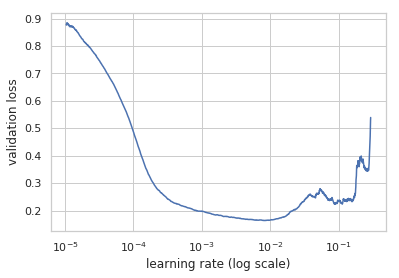

In [19]:
m = md.get_learner(**learner_params)
m.lr_find()
m.sched.plot()

In [20]:
lr = 1e-3
m = md.get_learner(**learner_params)
m.fit(lr, 5, cycle_len=3)

epoch      trn_loss   val_loss                                  
    0      0.140331   0.129495  
    1      0.123166   0.118639                                  
    2      0.120474   0.117474                                  
    3      0.110537   0.113699                                  
    4      0.105297   0.10865                                   
    5      0.101588   0.10798                                   
    6      0.10053    0.105416                                  
    7      0.096001   0.102451                                   
    8      0.095292   0.10212                                    
    9      0.093503   0.102928                                   
    10     0.090106   0.099895                                   
    11     0.090759   0.099125                                   
    12     0.092567   0.101045                                   
    13     0.088478   0.097288                                   
    14     0.086355   0.097346                    

[array([0.09735])]

In [21]:
save_model_ignoring(m, 'pretrain-noiser2-trn086-val097', ['outp'])

In [22]:
m.fit(lr, 5, cycle_len=3)

epoch      trn_loss   val_loss                                   
    0      0.088018   0.097957  
    1      0.086177   0.094634                                   
    2      0.0857     0.094195                                   
    3      0.087332   0.094894                                   
    4      0.08442    0.094211                                   
    5      0.081653   0.093377                                   
    6      0.085544   0.093146                                   
    7      0.08294    0.092404                                   
    8      0.082215   0.091655                                   
    9      0.084891   0.094449                                   
    10     0.082295   0.092362                                   
    11     0.082717   0.091526                                   
    12     0.084409   0.09347                                    
    13     0.080383   0.091254                                   
    14     0.079668   0.091095             

[array([0.0911])]

In [23]:
save_model_ignoring(m, 'pretrain-noiser-trn079-val091', ['outp'])

In [24]:
m.fit(lr, 5, cycle_len=3)

epoch      trn_loss   val_loss                                   
    0      0.084967   0.092455  
    1      0.080761   0.091308                                   
    2      0.078432   0.09077                                    
    3      0.083287   0.093344                                   
    4      0.081361   0.091002                                   
    5      0.07898    0.09043                                    
    6      0.08143    0.09251                                    
    7      0.080236   0.090195                                   
    8      0.078977   0.089922                                   
    9      0.083026   0.091723                                   
    10     0.077808   0.090058                                   
    11     0.079957   0.090133                                   
    12     0.080989   0.092132                                   
    13     0.078065   0.090185                                   
    14     0.078084   0.090291             

[array([0.09029])]

In [25]:
save_model_ignoring(m, 'pretrain-noiser-trn078-val090', ['outp'])

In [26]:
m.fit(lr, 5, cycle_len=3)

epoch      trn_loss   val_loss                                   
    0      0.081485   0.0917    
    1      0.078008   0.090314                                   
    2      0.076627   0.09                                       
    3      0.080734   0.091234                                   
    4      0.077566   0.09034                                    
    5      0.077331   0.089912                                   
    6      0.080264   0.091338                                   
    7      0.077816   0.089831                                   
    8      0.076679   0.089538                                   
    9      0.080579   0.091143                                   
    10     0.079106   0.090176                                   
    11     0.078439   0.089637                                   
    12     0.080664   0.092402                                   
    13     0.078309   0.090807                                   
    14     0.075504   0.089634             

[array([0.08963])]

In [27]:
save_model_ignoring(m, 'pretrain-noiser-trn075-val089', ['outp'])